# Snake Game DQN Training

This notebook provides a deep Q-learning based approach to train a snake game. The training process uses a DQN agent that tries to maximize its score by consuming apples while avoiding its own tail and walls. The game and the DQN agent's configuration can be modified using the globals provided.

## Table of Contents

1. Import Libraries
2. Editable Globals
3. Derived Globals
4. Plotting Functions
5. Main Execution

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import product
from copy import deepcopy
import matplotlib.colors as mcolors
import cProfile

## 2. Editable Globals

This section provides configuration parameters for the game mechanics and DQN agent training. 


In [2]:
# Game Configuration
PLAYABLE_GRID_SIZE = 5  # Playable grid without walls. Minimum value = 5

# Rewards
DEATH_PENALTY = -2
MOVEMENT_BONUS_NUMERATOR = 5  # Divided by the distance to the apple for actual bonus
APPLE_BONUS = 5
WIN_BONUS = 10
STARTING_SCORE = 0

# Hyperparameters
DECAY_RATE = (1 - 1e-6)
LEARNING_RATE = 1e-1
EPSILON = 9 * 1e-1
PRINT_FREQUENCY = 2**12
BUFFER_SIZE = 4096
BATCH_SIZE = 8192
GAMMA = 0.99
SYNC_FREQUENCY = 2**6
EPISODES = 2**23  #using 2**23 for actually running, less for profiling
SEED = 42


# === DERIVED GLOBALS (Do not edit unless refactoring) ===
IS_CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device("cuda" if IS_CUDA_AVAILABLE else "cpu")

TOTAL_GRID_SIZE = PLAYABLE_GRID_SIZE + 2  # Playable Area + Walls
INPUT_DIM = TOTAL_GRID_SIZE**2  # Size of the state passed to function
MAX_SNAKE_LENGTH = PLAYABLE_GRID_SIZE**2 - 1  # Winning calculated as snake reaching size of grid - 1

# Sets and Lists
EMPTY_GRID_SET = set((i, j) for i, j in product(range(1, TOTAL_GRID_SIZE - 1), repeat=2))  # Used for apple placement
EMPTY_STATE_NESTED_LIST = [[0 for _ in range(TOTAL_GRID_SIZE)] for _ in range(TOTAL_GRID_SIZE)]# Initialize blank grid with empty squares

# Defining walls on the EMPTY_STATE_NESTED_LIST
for i in range(TOTAL_GRID_SIZE):
    EMPTY_STATE_NESTED_LIST[0][i] = EMPTY_STATE_NESTED_LIST[i][0] = 1
    EMPTY_STATE_NESTED_LIST[TOTAL_GRID_SIZE - 1][i] = EMPTY_STATE_NESTED_LIST[i][TOTAL_GRID_SIZE - 1] = 1
flat_grid = [cell for row in EMPTY_STATE_NESTED_LIST for cell in row]
FLAT_GRID = torch.tensor(flat_grid)

## 3. Derived Globals

Derived globals are calculated based on the editable globals. These should not be edited unless you are refactoring the game mechanics or the DQN agent.


In [3]:
IS_CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device("cuda" if IS_CUDA_AVAILABLE else "cpu")

TOTAL_GRID_SIZE = PLAYABLE_GRID_SIZE + 2  # Playable Area + Walls
INPUT_DIM = TOTAL_GRID_SIZE**2  # Size of the state passed to function
MAX_SNAKE_LENGTH = PLAYABLE_GRID_SIZE**2 - 1  # Winning calculated as snake reaching size of grid - 1

# Sets and Lists
EMPTY_GRID_SET = set((i, j) for i, j in product(range(1, TOTAL_GRID_SIZE - 1), repeat=2))  # Used for apple placement
EMPTY_STATE_NESTED_LIST = [[0 for _ in range(TOTAL_GRID_SIZE)] for _ in range(TOTAL_GRID_SIZE)]# Initialize blank grid with empty squares

# Defining walls on the EMPTY_STATE_NESTED_LIST
for i in range(TOTAL_GRID_SIZE):
    EMPTY_STATE_NESTED_LIST[0][i] = EMPTY_STATE_NESTED_LIST[i][0] = 1
    EMPTY_STATE_NESTED_LIST[TOTAL_GRID_SIZE - 1][i] = EMPTY_STATE_NESTED_LIST[i][TOTAL_GRID_SIZE - 1] = 1
flat_grid = [cell for row in EMPTY_STATE_NESTED_LIST for cell in row]
FLAT_GRID = torch.tensor(flat_grid)

## 4. Plotting Functions

This section provides utility functions for visualization and game board rendering.

In [4]:
def plot_series(iterations_per_episode, scores_per_episode, length_per_episode):
    plt.figure(figsize=(18, 5))

    # Plot for iterations per episode
    plt.subplot(1, 3, 1)
    plt.plot(iterations_per_episode)
    plt.title("Iterations per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Iterations")

    # Plot for scores per episode
    plt.subplot(1, 3, 2)
    plt.plot(scores_per_episode)
    plt.title(f"Score per {PRINT_FREQUENCY} Episodes")
    plt.xlabel(f"Episodes time {PRINT_FREQUENCY}")
    plt.ylabel("Score")

    # Plot for length of the snake per episode
    plt.subplot(1, 3, 3)
    plt.plot(length_per_episode)
    plt.title("Length of the Snake per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Length")

    plt.tight_layout()
    plt.show()

def plot_game_board(state_tensor):

    # Convert tensor to numpy and reshape to a 2D grid
    grid = state_tensor.cpu().numpy().reshape(TOTAL_GRID_SIZE, TOTAL_GRID_SIZE)

    # Define a colormap: list of color names for empty, wall, body, apple, head, tail
    cmap = mcolors.ListedColormap(['white', 'black', 'green', 'red', 'darkgreen', 'lightgreen'])

    # Set the bounds for the colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)

    # Hide the axis
    ax.axis('off')

    plt.show()
    
def my_plot_fn(moving_avg_iterations, moving_avg_scores, moving_avg_length, eps, lr, episode, state_tensor, plot_board):   
    avg_iterations = sum(moving_avg_iterations) / len(moving_avg_iterations)
    avg_score = sum(moving_avg_scores) / len(moving_avg_scores)
    avg_length = sum(moving_avg_length) / len(moving_avg_length)

    print(f'''Episode: {episode} 
    Avg Iterations (last {PRINT_FREQUENCY} episodes): {avg_iterations:.2f} 
    Avg Score (last {PRINT_FREQUENCY}): {avg_score:.4f} 
    SnakeLength: {avg_length} 
    Eplsilon: {eps} 
    Learning Rate: {lr}
    ''')
    if plot_board:
        plot_game_board(state_tensor)
    return avg_iterations, avg_score, avg_length

## 4. Gameplay Functions

This section defines the game. Additionally, encode state turns the specifics of the game into a 1D tensor.

In [5]:
def encode_state(snake_queue, apple_location, score):
    # Start from a clone of the global tensor
    state = FLAT_GRID.clone()

    head_x, head_y = snake_queue[-1]
    tail_x, tail_y = snake_queue[0]
    apple_x, apple_y = apple_location

    # Convert 2D index to 1D index and set values in the flat tensor
    state[tail_x * TOTAL_GRID_SIZE + tail_y] = 5
    state[apple_x * TOTAL_GRID_SIZE + apple_y] = 3
    state[head_x * TOTAL_GRID_SIZE + head_y] = 4

    # Assign values for the snake's body
    for segment_x, segment_y in snake_queue[1:]:
        state[segment_x * TOTAL_GRID_SIZE + segment_y] = 2

    return state


In [6]:
class Direction(Enum):
    UP =    [1, 0, 0, 0]
    DOWN =  [0, 1, 0, 0]
    LEFT =  [0, 0, 1, 0]
    RIGHT = [0, 0, 0, 1]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if IS_CUDA_AVAILABLE:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def eat_apple(snake_queue):
    new_apple_location = random.choice(list(EMPTY_GRID_SET - set(snake_queue)))
    return new_apple_location

def initialize_game(starting_head_location, starting_apple_location):
    snake_queue = [starting_head_location]
    apple_location = starting_apple_location
    score = STARTING_SCORE
    game_over = False
    return game_over, snake_queue, apple_location, score

def update_state(snake_queue, apple_location, direction, score, num_moves):
    num_moves += 1
    def move_snake(snake_queue, direction):
        head_location = snake_queue[-1]
        # Update head_location based on the direction
        if direction == Direction.UP: # Up
            head_location = (head_location[0]-1, head_location[1])
        elif direction == Direction.DOWN: # Down
            head_location = (head_location[0]+1, head_location[1])
        elif direction == Direction.LEFT: # Left
            head_location = (head_location[0], head_location[1]-1)
        else: # Right
            head_location = (head_location[0], head_location[1]+1)
        return head_location

    def score_and_process_move(head_location, snake_queue, apple_location, score, num_moves):
        distance_to_apple = ((head_location[0]-apple_location[0])**2 + (head_location[1]-apple_location[1])**2)**0.5
        walls = [0, TOTAL_GRID_SIZE - 1]
        if head_location == apple_location:
            num_moves = 0
            score += APPLE_BONUS 
            apple_location = eat_apple(snake_queue)
            snake_queue.append(head_location)
        else:
            snake_queue.pop(0)
            if (head_location in snake_queue) or (head_location[0] in walls or head_location[1] in walls):
                score += DEATH_PENALTY
                snake_queue.append(head_location)
                return True, snake_queue, apple_location, score, num_moves
            # Snake just moves
            else:
                snake_queue.append(head_location)
                score += MOVEMENT_BONUS_NUMERATOR / distance_to_apple / (num_moves + 1)
        if len(snake_queue) == MAX_SNAKE_LENGTH:
            score += WIN_BONUS
            return True, snake_queue, apple_location, score, num_moves
        return False, snake_queue, apple_location, score, num_moves
    head_location = move_snake(snake_queue, direction)
    done, snake_queue, apple_location, score, num_moves =  score_and_process_move(head_location, snake_queue, apple_location, score, num_moves)
    return done, snake_queue, apple_location, score, num_moves


## 6. Model Initiation

This section defines the model.

In [7]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(
            *random.sample(self.buffer, batch_size))
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

In [9]:
class DQNAgent:
    def __init__(self, input_dim, output_dim, gamma=GAMMA, learning_rate=LEARNING_RATE, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
        self.device = DEVICE
        self.dqn = DQN(input_dim, output_dim).to(self.device)
        self.target = DQN(input_dim, output_dim).to(self.device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval() # Set the target network to evaluation mode
        
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = EPSILON
    
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)

        # Convert to tensors
        state = torch.stack(state).to(self.device)       # Convert list of tensors to a tensor
        action = torch.LongTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.stack(next_state).to(self.device) # Convert list of tensors to a tensor
        done = torch.FloatTensor(done).to(self.device)

        # Compute Q-values
        curr_Q = self.dqn(state).gather(1, action.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target(next_state).max(1)[0]
        expected_Q = reward + (1 - done) * self.gamma * next_Q

        # Compute loss and update the network
        loss = self.loss_fn(curr_Q, expected_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, state):
        state = state.to(torch.float32).to(self.device)  # Ensure state is on the correct device
        with torch.no_grad():
            if random.random() > self.epsilon:
                action_index = int(self.dqn(state).max(0)[1])
            else:
                action_index = random.randint(0, 3)  # Assuming you have 4 possible actions
        return action_index
                
    def decay_epsilon(self):
        self.epsilon *= DECAY_RATE
        self.epsilon = max(self.epsilon, 0.01)
        '''
        # Decay the learning rate
        #self.optimizer.param_groups[0]['lr'] *= DECAY_RATE
        #self.optimizer.param_groups[0]['lr'] = max(self.optimizer.param_groups[0]['lr'], 0.001)
        '''
    def get_epsilon(self):
        return self.epsilon
    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']        
    def sync_target(self):
        self.target.load_state_dict(self.dqn.state_dict())

## 7. Main Execution

Number of GPUs: 0
Device: cpu
Episode: 4095 
    Avg Iterations (last 4096 episodes): 6.52 
    Avg Score (last 4096): 1.7614 
    SnakeLength: 1.1728515625 
    Eplsilon: 0.8963220339360848 
    Learning Rate: 0.1
    
Episode: 8191 
    Avg Iterations (last 4096 episodes): 6.42 
    Avg Score (last 4096): 1.6267 
    SnakeLength: 1.16845703125 
    Eplsilon: 0.8926582056957006 
    Learning Rate: 0.1
    
Episode: 12287 
    Avg Iterations (last 4096 episodes): 6.56 
    Avg Score (last 4096): 1.6888 
    SnakeLength: 1.162353515625 
    Eplsilon: 0.8890093538107648 
    Learning Rate: 0.1
    
Episode: 16383 
    Avg Iterations (last 4096 episodes): 6.43 
    Avg Score (last 4096): 1.6520 
    SnakeLength: 1.162353515625 
    Eplsilon: 0.8853754170635548 
    Learning Rate: 0.1
    
Episode: 20479 
    Avg Iterations (last 4096 episodes): 6.56 
    Avg Score (last 4096): 1.7568 
    SnakeLength: 1.17578125 
    Eplsilon: 0.8817563344865778 
    Learning Rate: 0.1
    
Episode: 24575

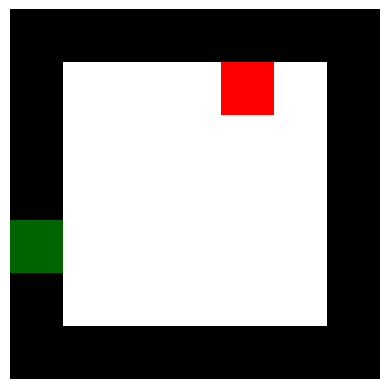

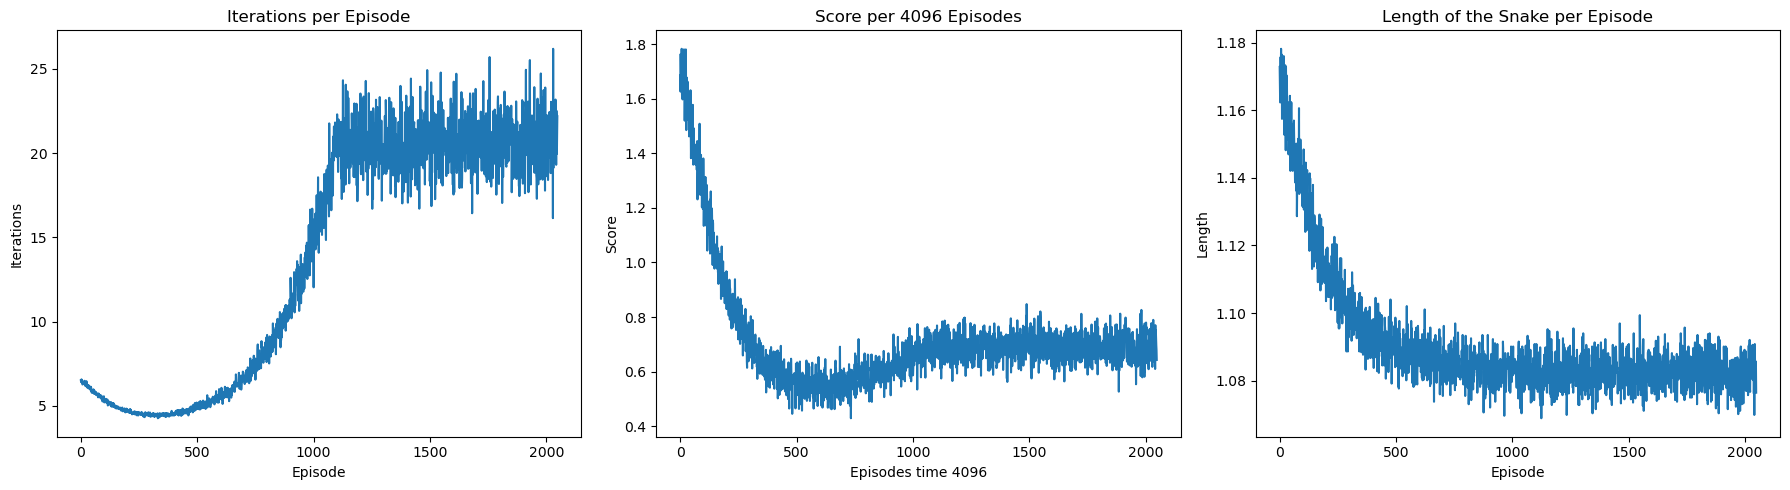

         8008109446 function calls (7242535010 primitive calls) in 15477.747 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.894    0.894 100992995.py:1(plot_series)
        1    0.000    0.000    0.111    0.111 100992995.py:28(plot_game_board)
     2048    0.038    0.000    0.817    0.000 100992995.py:49(my_plot_fn)
108292443  274.162    0.000 8170.588    0.000 1253078346.py:11(forward)
        2    0.000    0.000    0.023    0.011 1253078346.py:2(__init__)
        1  512.293  512.293 15478.192 15478.192 15742921.py:1(main)
113958164   37.339    0.000   56.393    0.000 2059157542.py:14(__len__)
        1    0.000    0.000    0.000    0.000 2059157542.py:2(__init__)
113958164   82.283    0.000  270.758    0.000 2059157542.py:5(push)
   763111    3.277    0.000    5.321    0.000 3602528358.py:15(eat_apple)
  8388608    4.351    0.000    4.351    0.000 3602528358.py:19(initialize_game)
1139581

In [10]:
def main():
    """
    Main function to train the DQN agent on the snake game.
    
    This function initializes the game environment and the DQN agent, and then executes the training episodes.
    Throughout the training, the function records statistics like average scores, iterations, and snake lengths to visualize the agent's progress.
    """

    # Lists to store statistics for plotting later
    iterations_plot_list = []
    scores_plot_list = []
    length_plot_list = []

    # Deques for moving average calculations over episodes
    moving_avg_iterations = deque(maxlen=PRINT_FREQUENCY)
    moving_avg_scores = deque(maxlen=PRINT_FREQUENCY)
    moving_avg_length = deque(maxlen=PRINT_FREQUENCY)

    # Initialize the DQN agent
    agent = DQNAgent(input_dim=INPUT_DIM , output_dim=4)
    
    # Ensure consistent CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Action mapping to game directions
    action_mapping = {0: Direction.UP, 1: Direction.DOWN, 2: Direction.LEFT, 3: Direction.RIGHT}
    
    # Set a deterministic seed for reproducibility
    set_seed(SEED)

    # Display information about available GPUs and the device being used
    print(f'Number of GPUs: {torch.cuda.device_count()}')
    print(f'Device: {torch.device("cuda" if IS_CUDA_AVAILABLE else "cpu")}')

    # Main training loop
    for episode in range(EPISODES):
        iteration_count = 0
        num_moves = 0
        
        # Initialize game with a random starting position for snake and apple
        starting_head_location = random.choice(list(EMPTY_GRID_SET))
        starting_apple_location = random.choice(list(EMPTY_GRID_SET - set(starting_head_location)))
        
        done, snake_queue, apple_location, score = initialize_game(starting_head_location, starting_apple_location)
        
        # Convert game state to a tensor representation
        state = encode_state(snake_queue, apple_location, score)

        # Episode loop
        while not done:
            action_index = agent.get_action(state)
            done, snake_queue, apple_location, score, num_moves = update_state(snake_queue, apple_location, action_mapping[action_index], score, num_moves)
            state = encode_state(snake_queue, apple_location, score)
            agent.buffer.push(state, action_index, score, state, done)
            agent.update()
            iteration_count += 1

        # Update moving averages for this episode
        moving_avg_iterations.append(iteration_count)
        moving_avg_scores.append(score)
        moving_avg_length.append(len(snake_queue))

        # Print and plot statistics every PRINT_FREQUENCY episodes
        if ((episode + 1) % PRINT_FREQUENCY == 0):
            eps = agent.get_epsilon()
            lr = agent.get_lr()
            plot_board = False
            avg_iterations, avg_score, avg_length = my_plot_fn(moving_avg_iterations, moving_avg_scores, moving_avg_length, eps, lr, episode, state, plot_board)
            
            # Update the lists for final plotting
            iterations_plot_list.append(avg_iterations)
            scores_plot_list.append(avg_score)
            length_plot_list.append(avg_length)

        # Decay the exploration factor epsilon
        agent.decay_epsilon()
        
        # Sync target network weights with main network weights periodically
        if episode % SYNC_FREQUENCY == 0:
            agent.sync_target()

    # Final visualizations after training completion
    plot_game_board(state)
    plot_series(iterations_plot_list, scores_plot_list, length_plot_list)

# Profiling the main function to analyze performance
cProfile.run('main()')


Absolutely! Systematic hyperparameter tuning and debugging is crucial in reinforcement learning to ensure efficient learning. Let's outline a structured approach:

1. Baseline and Simplification:
Start with a simpler version of the problem. Perhaps a smaller grid or an environment where the apple is always in the same place.
Make the network as simple as possible. Once you see it learning, gradually increase its complexity.
2. Diagnosis:
Visualizations: Visualize the agent's decisions over time. Is it exploring enough? Is it getting stuck in a loop?
Reward Analysis: Print the rewards obtained during each step. Is the agent getting the expected rewards for its actions?
Gradient Checks: Monitor the magnitude of the gradients. If they're too small, you might be dealing with vanishing gradients; if they're too large, exploding gradients.
Q-value Analysis: Plot the Q-values over time. Are they diverging or converging? Are they increasing for the correct actions and decreasing for the incorrect ones?
Action Distribution: Check the distribution of actions taken by the agent. Is it too biased towards one action? This can indicate that the agent has found a loophole in the reward system or isn't exploring enough.
3. Hyperparameter Tuning:
Grid Search: Start with broader ranges for hyperparameters like learning rate, epsilon decay, etc., and then narrow down.
Random Search: Sometimes better than grid search, as it can explore the hyperparameter space more diversely.
Bayesian Optimization: Tools like Optuna, Hyperopt, or frameworks like Ray Tune can be very efficient for hyperparameter tuning in RL.
4. Incremental Changes:
Change one thing at a time and observe its impact. If you adjust multiple things and something goes wrong (or right), you won't know what caused it.
5. Check Environment Dynamics:
Ensure there are no bugs in the environment itself, as these can majorly affect learning.
6. Reproducibility:
Start with established, reproducible baselines or reference implementations. If a well-known algorithm doesn't work in your environment, it's a strong signal that something might be off.
7. Alternative Approaches:
Curriculum Learning: Start with easier tasks and gradually move to complex ones.
Reward Shaping: Sometimes, a more frequent, intermediate reward can guide the agent better than a sparse reward.
Transfer Learning: If you have a model trained on a similar task, you can fine-tune it on your current task.
8. Review Model Architecture:
Ensure that the architecture is suitable for the task. Sometimes a simple feed-forward network might not suffice, and you might need recurrent layers or other architectures.
Check the initialization methods for your neural network layers.
9. Regular Monitoring and Logging:
Tools like TensorBoard or Weights & Biases can be invaluable. Log scalars like loss, average reward, epsilon, and more complex data like histograms of network weights, Q-values, or even images of the game state.
Remember, in RL, especially in environments with high variance, it's often valuable to run multiple seeds (starting points) and average the results to ensure the changes you're observing aren't just due to randomness.


Your model's performance seems to be fluctuating with a limited increase in average score and snake length over the episodes. Let's troubleshoot:

Learning Rate and Decay: Your learning rate LEARNING_RATE = 1e-2 is relatively high for a deep learning problem, especially when it is decaying at every episode. As the learning rate drops, the model might make smaller and smaller updates, leading to slow or stalled learning. Consider using a slightly higher learning rate or decaying it less frequently.

Reward Structure: The reward structure plays a critical role in RL. Let's analyze:

MOVEMENT_BONUS: It's quite high for just moving. This might encourage the snake to move around without necessarily targeting the apple.
WALL_PENALTY: It's a good idea to penalize the snake for hitting the wall. However, consider the magnitude. Is -10 too low or too high relative to other rewards?
WIN_BONUS: This bonus is huge compared to other rewards. While this can incentivize winning, the agent might never achieve this state if it's too focused on smaller rewards (like movement).
Epsilon Decay: Your epsilon is decaying at a rate of 1e-5 which means it will approach its minimum quite slowly. This means that exploration will continue to dominate for many episodes. It might be worthwhile to allow the agent to exploit its knowledge sooner by adjusting the decay rate or setting a threshold episode after which epsilon decreases more rapidly.

Network Architecture: We haven't seen the architecture of the DQN. The model's complexity, layers, and activation functions can impact its ability to learn. Consider experimenting with different architectures.

Replay Buffer: How is your buffer implemented? Too small a buffer can cause the agent to forget previous experiences quickly. On the other hand, a very large buffer might make the agent focus too much on older experiences. Also, the sampling strategy can make a difference. Prioritized experience replay can sometimes enhance learning.

Initialization: How are the weights of your DQN initialized? Poor initialization can hamper learning.

Training Frequency: Consider adjusting how often you sync the target network with the DQN. Syncing too frequently can lead to chasing a moving target, while too infrequent can slow down learning.

Exploration vs. Exploitation: Printing the epsilon value periodically will give insight into how much exploration vs. exploitation is being done. If it's still in a high exploration mode, consider adjusting the decay.

Environment Dynamics: Ensure that the environment (like apple placement, snake initialization) does not have any bugs or undesired behaviors that can affect learning.

Visual Analysis: Sometimes, it's beneficial to visually observe the agent in action. Look for any repetitive or strange behaviors.

Grad Check: Ensure gradients aren't vanishing or exploding during backpropagation. This can be done by checking the norms of the gradients.

After making any changes, it's essential to retrain and observe the agent's behavior. Remember, deep reinforcement learning can be sensitive to hyperparameters and often requires multiple iterations and tweaks for convergence.